In [1]:
# Thư viện sử dụng
import pandas as pd
from sklearn.model_selection import train_test_split
from pyvi import ViTokenizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Maxent
class MaxEntClassifier:
    def __init__(self):
        self.model = None
        self.vectorizer = DictVectorizer()

    def train(self, X_train, y_train):
        X_train = [self._extract_features(x) for x in X_train]
        X_train = self.vectorizer.fit_transform(X_train)
        self.model = LogisticRegression(solver='lbfgs', multi_class='auto')
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        X_test = [self._extract_features(x) for x in X_test]
        X_test = self.vectorizer.transform(X_test)
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        X_test = [self._extract_features(x) for x in X_test]
        X_test = self.vectorizer.transform(X_test)
        return self.model.score(X_test, y_test)

    def _extract_features(self, sentence):
        features = {}
        for i, token in enumerate(sentence.split()):
            features[f'word_{i}'] = token
        return features

    def get_feature_weights(self):
        feature_names = self.vectorizer.get_feature_names_out()
        coefficients = self.model.coef_

        weights_df = pd.DataFrame(coefficients, columns=feature_names, index=self.model.classes_)
        return weights_df

In [3]:
# Tạo DataFrame mới chỉ chứa 2 cột "Summary" và "Category"
data = pd.read_excel("data.xlsx") #thay thế bằng dữ liệu sau tiền xử lý
df = data.copy()
maxent_train_data = df[["tokenized_contents", "Category"]]

In [4]:
# Chia dữ liệu huấn luyện thành tập huấn luyện và tập validation
maxent_train_data, maxent_val_data = train_test_split(maxent_train_data, test_size=0.2, random_state=42)

In [5]:
# Khởi tạo mô hình MaxEnt
clf = MaxEntClassifier()

# Huấn luyện mô hình trên dữ liệu huấn luyện
clf.train(maxent_train_data['tokenized_contents'], maxent_train_data['Category'])

In [6]:
# Đánh giá mô hình trên tập validation
y_maxent_pred = clf.predict(maxent_val_data['tokenized_contents'])
maxent_accuracy = accuracy_score(maxent_val_data['Category'], y_maxent_pred)
maxent_report = classification_report(maxent_val_data['Category'], y_maxent_pred)

In [7]:
# Lưu mô hình vào tệp tin 'maxent_model.joblib'
joblib.dump(clf, 'maxent_model.joblib')

['maxent_model.joblib']

In [8]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Sử dụng mô hình (Mẫu)

# Bộ dữ liệu kiểm tra
new_sentences = ["Sự phát triển của ngành công nghiệp điện ảnh đã tạo ra nhiều phim ảnh sáng tạo và hấp dẫn, mang đến cho khán giả trải nghiệm giải trí độc đáo.",
                 "Công nghệ AI đang thay đổi cách chúng ta tương tác với thế giới, từ việc giúp chúng ta tìm kiếm thông tin nhanh chóng đến việc tạo ra trợ lý ảo thông minh.",
                 "Thay đổi khí hậu đang là một vấn đề toàn cầu cấp bách, yêu cầu sự hợp tác và hành động quyết liệt từ tất cả các quốc gia trên thế giới."]

# Tiền xử lý dữ liệu kiểm tra
test_data = pd.DataFrame({"Sentence": new_sentences})

# Dự đoán nhãn cho dữ liệu kiểm tra
predictions = clf.predict(test_data['Sentence'])

for sentence, label in zip(test_data['Sentence'], predictions):
    print(f"Sentence: {sentence}")
    print(f"Predicted label: {label}")
    print()

Sentence: Sự phát triển của ngành công nghiệp điện ảnh đã tạo ra nhiều phim ảnh sáng tạo và hấp dẫn, mang đến cho khán giả trải nghiệm giải trí độc đáo.
Predicted label: Văn hóa - Giải trí

Sentence: Công nghệ AI đang thay đổi cách chúng ta tương tác với thế giới, từ việc giúp chúng ta tìm kiếm thông tin nhanh chóng đến việc tạo ra trợ lý ảo thông minh.
Predicted label: Gia đình - Hôn nhân

Sentence: Thay đổi khí hậu đang là một vấn đề toàn cầu cấp bách, yêu cầu sự hợp tác và hành động quyết liệt từ tất cả các quốc gia trên thế giới.
Predicted label: Gia đình - Hôn nhân



In [9]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Biểu diễn trực quan mô hình (Dự đoán - Thực tế)

# Thư viện sử dụng
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import numpy as np

In [10]:
maxent_report = classification_report(maxent_val_data['Category'], y_maxent_pred, output_dict=True)

# Chuyển kết quả đánh giá thành DataFrame
report_df = pd.DataFrame(maxent_report).transpose()

# In kết quả đánh giá
print(f"Chỉ số chính xác của mô hình: {maxent_accuracy:.2}\n")

# Sắp xếp theo thứ tự giảm dần của các chỉ số precision, recall và f1-score
report_df_sorted = report_df.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)
report_df_sorted

Chỉ số chính xác của mô hình: 0.73



,precision,recall,f1-score,support
Thông tin tiện ích,1.000000,0.714286,0.833333,21.000000
Tin tức việc làm,1.000000,0.263158,0.416667,38.000000
Tấm Lòng Vàng,0.913793,0.679487,0.779412,156.000000
Thể thao,0.848958,0.871658,0.860158,187.000000
Giáo dục,0.836957,0.823529,0.830189,187.000000
Bất động sản,0.826347,0.745946,0.784091,185.000000
Xe +,0.801527,0.690789,0.742049,152.000000
Pháp luật,0.801075,0.768041,0.784211,194.000000
Công nghệ,0.800000,0.517241,0.628272,116.000000
macro avg,0.790402,0.695154,0.717622,1989.000000


In [11]:
# Đánh giá mô hình trên tập validation
y_maxent_pred = clf.predict(maxent_val_data['tokenized_contents'])

maxent_accuracy = accuracy_score(maxent_val_data['Category'], y_maxent_pred)
maxent_precision = precision_score(maxent_val_data['Category'], y_maxent_pred, average='weighted')
maxent_recall = recall_score(maxent_val_data['Category'], y_maxent_pred, average='weighted')
maxent_f1 = f1_score(maxent_val_data['Category'], y_maxent_pred, average='weighted')

# In kết quả đánh giá
print(f"Accuracy on validation data: {maxent_accuracy:.4f}")
print(f"Precision on validation data: {maxent_precision:.4f}")
print(f"Recall on validation data: {maxent_recall:.4f}")
print(f"F1-score on validation data: {maxent_f1:.4f}")

Accuracy on validation data: 0.7325
Precision on validation data: 0.7546
Recall on validation data: 0.7325
F1-score on validation data: 0.7324


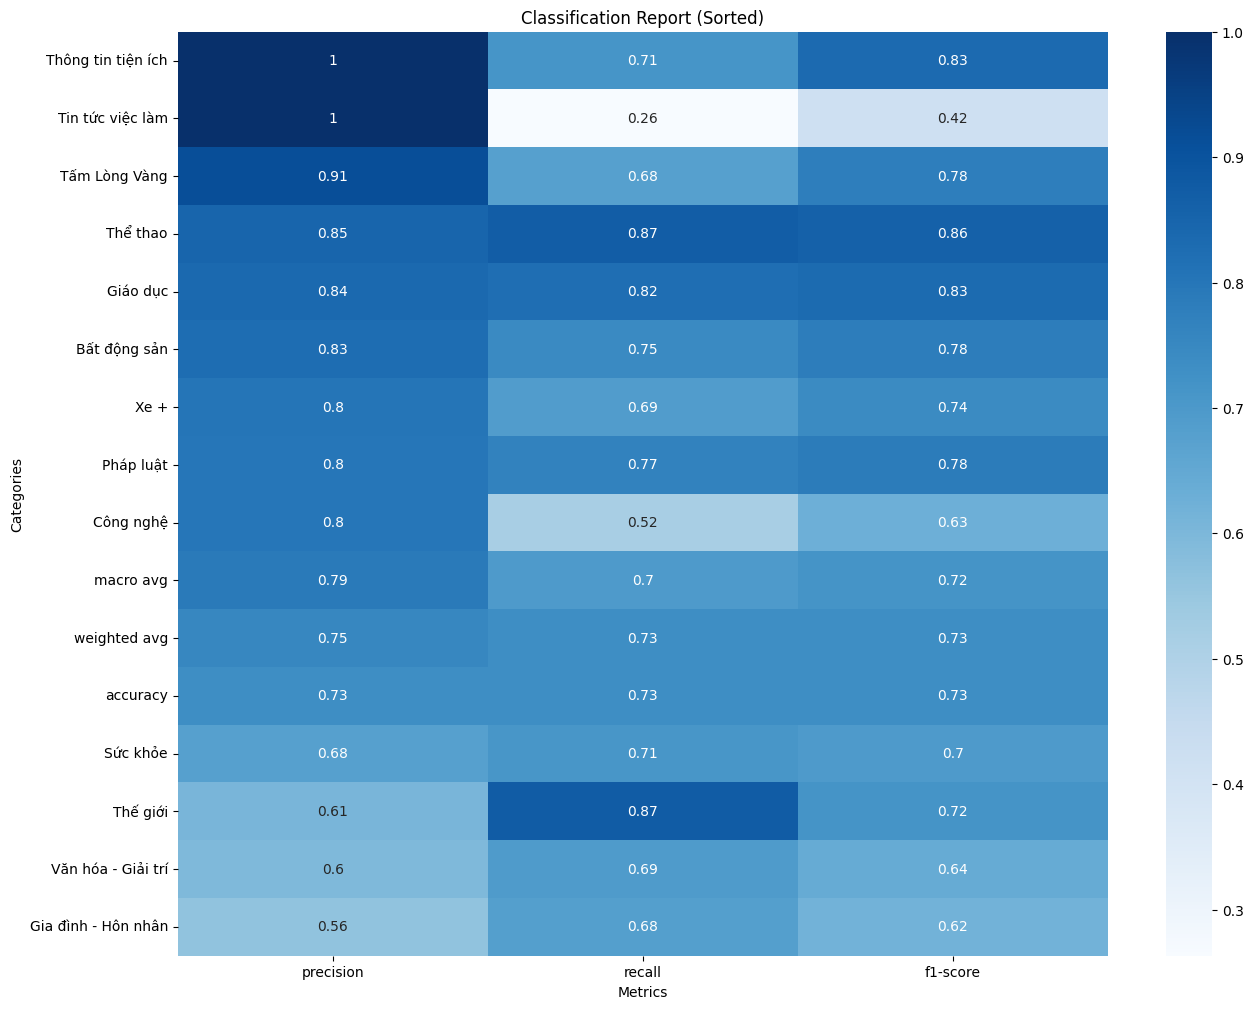

In [12]:
# Trực quan hóa kết quả đánh giá bằng biểu đồ
plt.figure(figsize=(15, 12))
sns.heatmap(report_df_sorted.iloc[:, :-1], annot=True, cmap='Blues')
plt.xlabel('Metrics')
plt.ylabel('Categories')
plt.title('Classification Report (Sorted)')
plt.show()

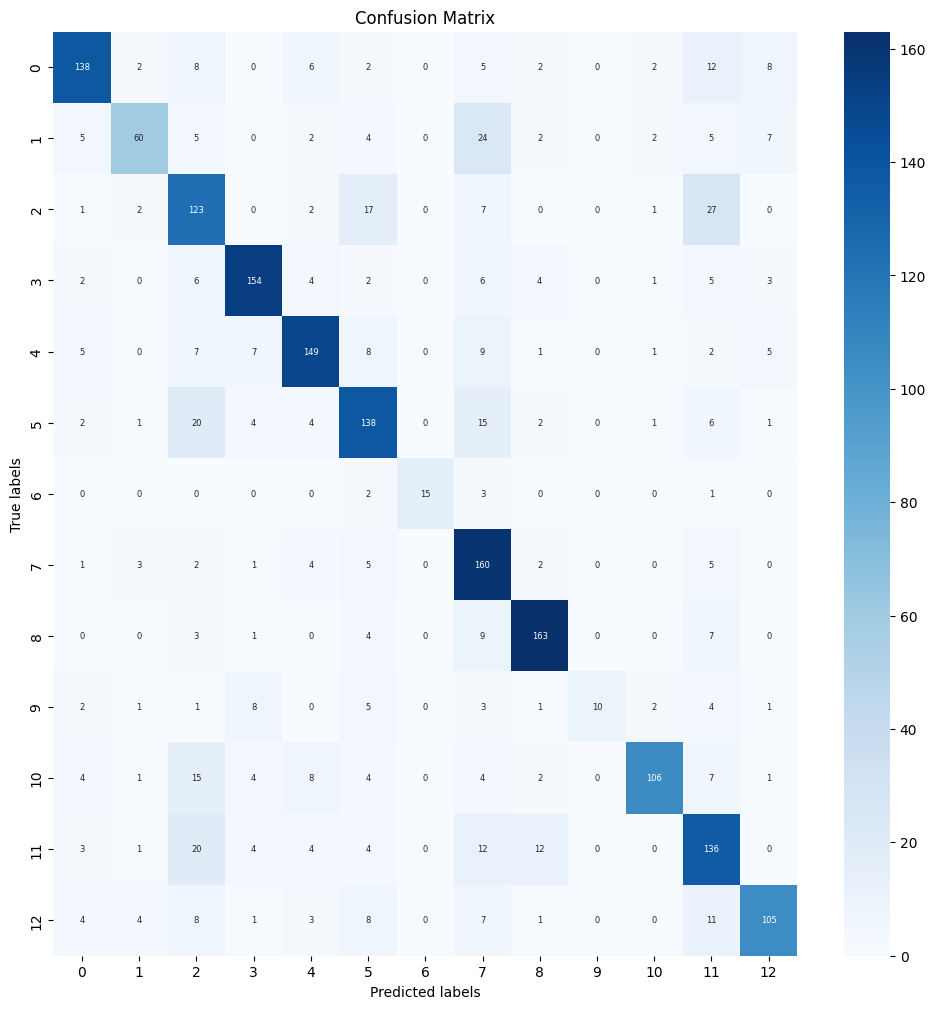

In [13]:
# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(maxent_val_data['Category'], y_maxent_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 6})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

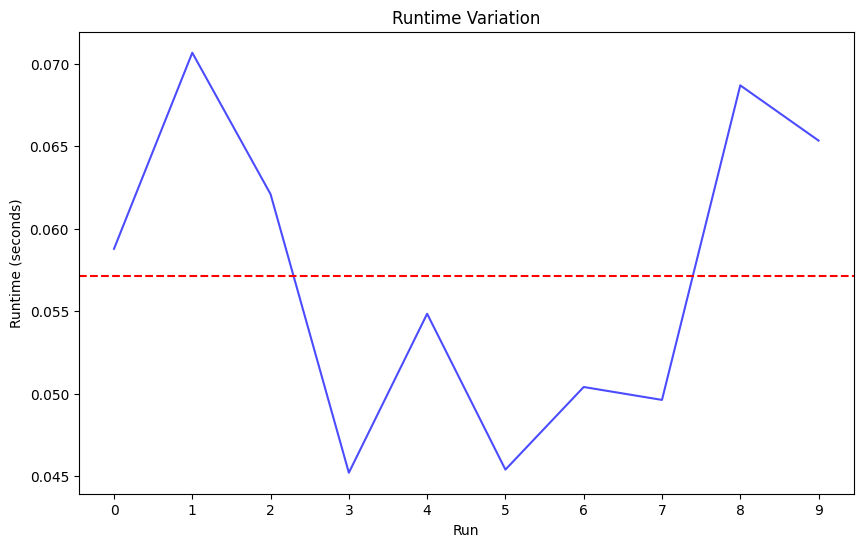

In [15]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Timing

# Biểu đồ cột thể hiện giao động của thời gian thời gian tính chỉ số chính xác cho thuật toán
num_runs = 10
runtimes = []

for _ in range(num_runs):
    start_time = time.time()

    # Đoạn mã để chạy thuật toán
    y_maxent_pred = clf.predict(maxent_val_data['tokenized_contents'])
    maxent_accuracy = accuracy_score(maxent_val_data['Category'], y_maxent_pred)

    end_time = time.time()
    runtime = end_time - start_time
    runtimes.append(runtime)

# Biểu diễn trực quan
plt.figure(figsize=(10, 6))
plt.plot(range(num_runs), runtimes, color='blue', alpha=0.7)
plt.axhline(y=np.mean(runtimes), color='red', linestyle='--')
plt.xlabel('Run')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Variation')
plt.xticks(range(num_runs))
plt.show()

In [16]:
runtimes

[0.05877852439880371,
 0.07066583633422852,
 0.062090396881103516,
 0.045206308364868164,
 0.05484175682067871,
 0.04539370536804199,
 0.05040240287780762,
 0.04962015151977539,
 0.06868743896484375,
 0.06534004211425781]